## Daily Trading Limit

In [25]:
#Load packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [37]:
#Load data
df = pd.read_excel("DTL_Data.xlsx", engine = "openpyxl") 

#Parse date column and set it as the index
df["Date"] = pd.to_datetime(df.iloc[:, 0]) 
df.set_index('Date', inplace = True)

#Remove NAs
df.dropna(inplace = True)

df.tail()

,Capital Surplus,Accounting
Date,,
2025-06-10,44997337.0,2.310912e+09
2025-06-11,38219581.0,1.589020e+09
2025-06-12,9849080.0,1.704953e+08
2025-06-13,28881744.0,1.435011e+09
2025-06-17,20217886.0,9.770330e+08


### Plot original date

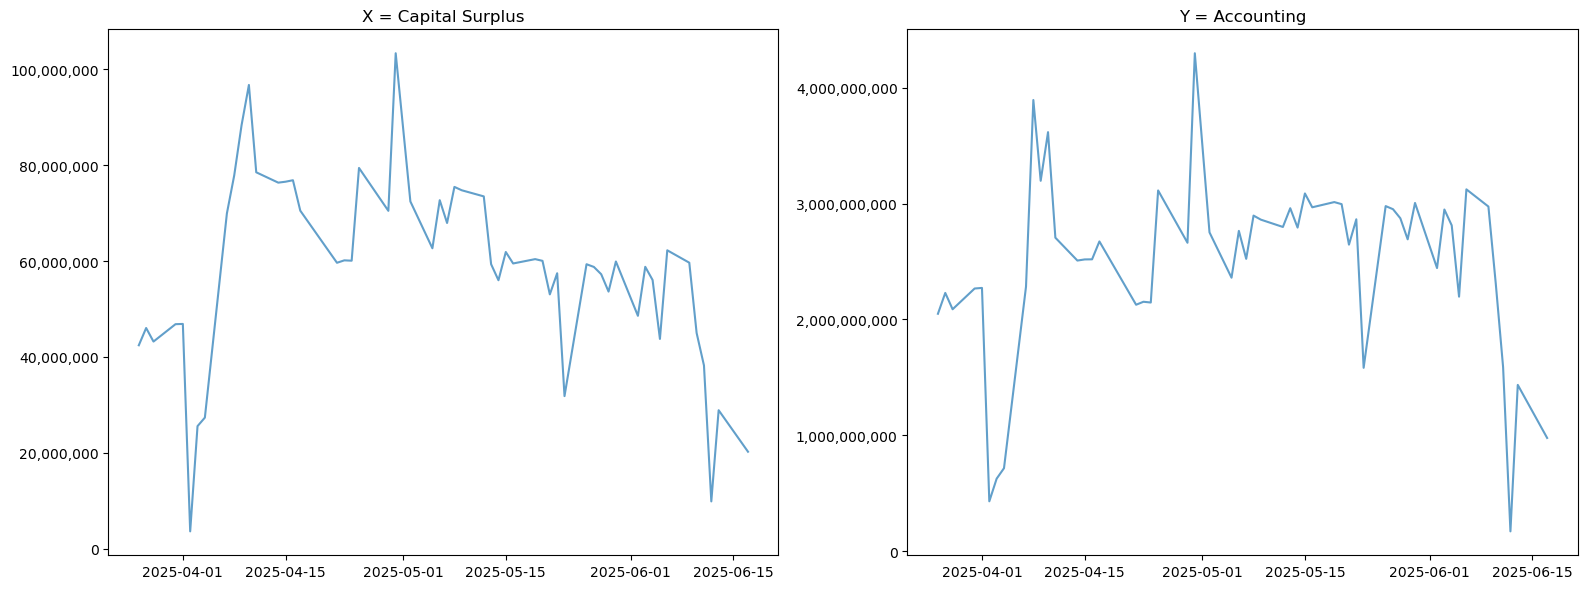

In [33]:
# Creating the plt object
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

ax1.plot(df.index, df['Capital Surplus'], alpha = 0.7)
ax1.set_title('X = Capital Surplus')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}')) # Format y-axis to avoid scientific notation

ax2.plot(df.index, df['Accounting'], alpha = 0.7)
ax2.set_title('Y = Accounting')
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

### Check for Stationarity

In [34]:
# ADF Test
def adf_test(series, name):
    result = adfuller(series)
    print(f'ADF Test for {name}')
    print(f'Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('---')


adf_test(df['Capital Surplus'], 'Capital Surplus')
adf_test(df['Accounting'], 'Accounting')


ADF Test for Capital Surplus
Statistic: -1.9085193421834372
p-value: 0.3280640181605029
---
ADF Test for Accounting
Statistic: -2.753863841426901
p-value: 0.0651721681371381
---


If p-value > 0.05, difference the series to make it stationary:

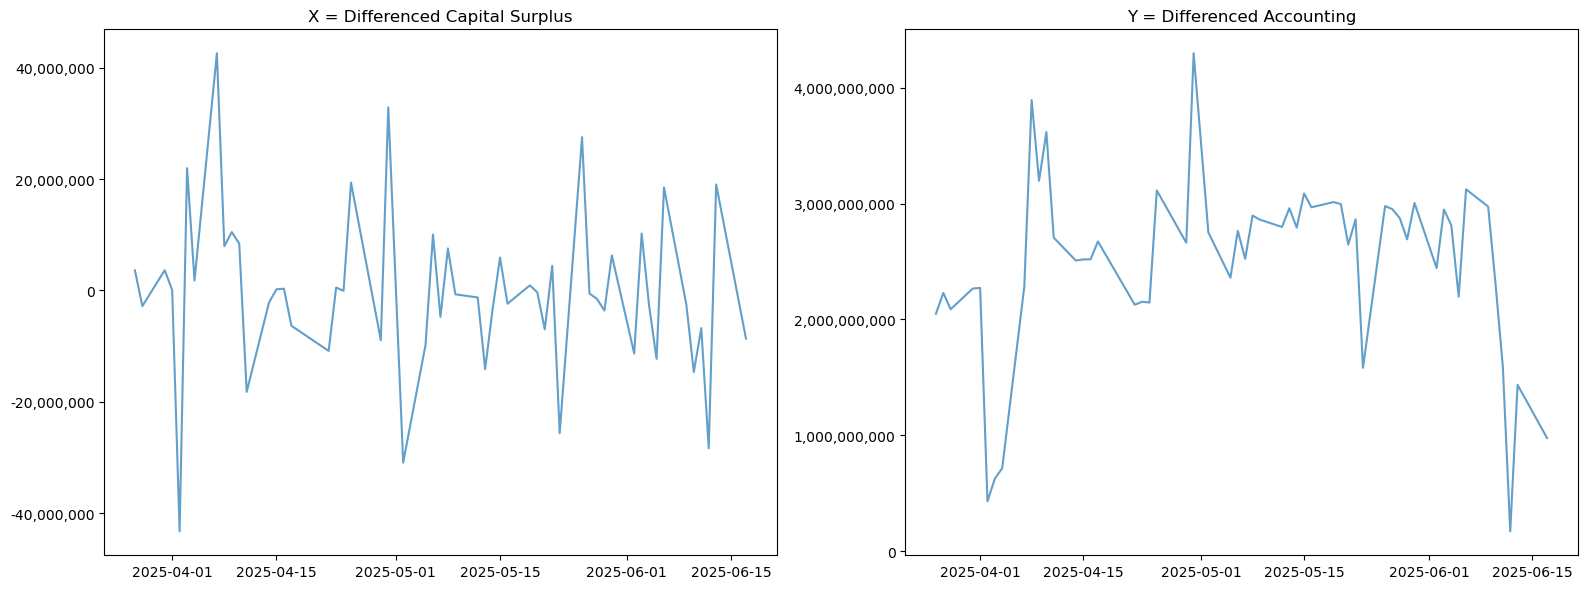

In [38]:
#Difference
df["Capital Surplus D1"] = df['Capital Surplus'].diff().dropna()
df["Accounting D1"] = df['Accounting'].diff().dropna()

# Creating the plt object
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

ax1.plot(df.index, df['Capital Surplus D1'], alpha = 0.7)
ax1.set_title('X = Differenced Capital Surplus')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}')) # Format y-axis to avoid scientific notation

ax2.plot(df.index, df['Accounting'], alpha = 0.7)
ax2.set_title('Y = Differenced Accounting')
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

In [40]:
adf_test(df['Capital Surplus D1'].dropna(), 'Capital Surplus D1')
adf_test(df['Accounting D1'].dropna(), 'Accounting D1')

ADF Test for Capital Surplus D1
Statistic: -9.66848120581919
p-value: 1.2958932845148446e-16
---
ADF Test for Accounting D1
Statistic: -9.297871404363537
p-value: 1.1332154750780323e-15
---


### Automatically Choose Best Order (p, d, q)

In [81]:
!pip install pmdarima

from pmdarima.arima import auto_arima

stepwise_model = auto_arima(df['Accounting'], seasonal = False, trace = True)
print(stepwise_model.summary())

#========================Manually=================================================================================
#import pmdarima as pm

# Automatically find best ARIMA(p,d,q) including differencing (d)
#stepwise_model = pm.auto_arima(
#    df['Capital Surplus'], 
#    start_p=0, max_p=5,
#    start_q=0, max_q=5,
#    d=None,               # Let auto_arima test for differencing
#    seasonal=False,       # Set True if your data is seasonal
#    stepwise=True,        # Efficient stepwise search
#    trace=True,           # Show progress
#    error_action='ignore',# Ignore orders that fail to converge
#    suppress_warnings=True,
#    n_jobs=-1             # Use multiple cores for speed (optional)
#)

#print(stepwise_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2542.830, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2404.102, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2510.855, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2402.839, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=2404.814, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2404.809, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2402.962, Time=0.01 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2406.809, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2395.193, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2393.386, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2412.950, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2395.473, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2401.819, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : 

In [119]:
# Fit ARIMA model 
model_2 = ARIMA(df['Accounting'], order = (1, 3, 2)) 
result_2 = model_2.fit()

# Summary
print(result_2.summary())

                               SARIMAX Results                                
Dep. Variable:             Accounting   No. Observations:                   55
Model:                 ARIMA(1, 3, 2)   Log Likelihood               -1140.474
Date:                Wed, 18 Jun 2025   AIC                           2288.948
Time:                        10:43:45   BIC                           2296.753
Sample:                             0   HQIC                          2291.940
                                 - 55                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2109      0.204     -1.033      0.301      -0.611       0.189
ma.L1         -1.9360      0.236     -8.198      0.000      -2.399      -1.473
ma.L2          0.9455      0.232      4.071      0.0

C:\Users\lwando.mbanguta.psc\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lwando.mbanguta.psc\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lwando.mbanguta.psc\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lwando.mbanguta.psc\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA par

### Model Diagnostics

Model 1 (Autoregressive with intercept): $$ Y_t = \alpha + \beta Y_{t-1} + \epsilon_t$$

C:\Users\lwando.mbanguta.psc\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lwando.mbanguta.psc\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lwando.mbanguta.psc\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


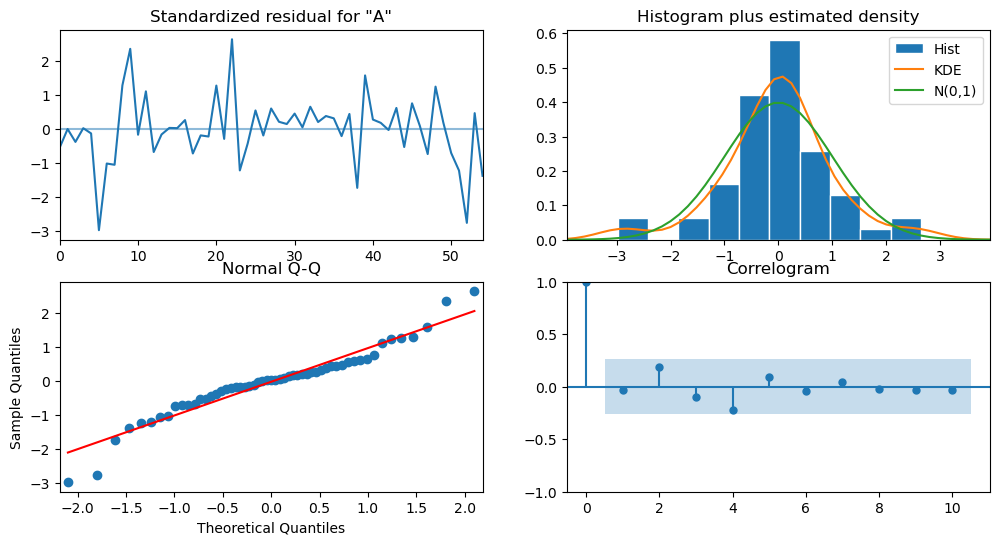

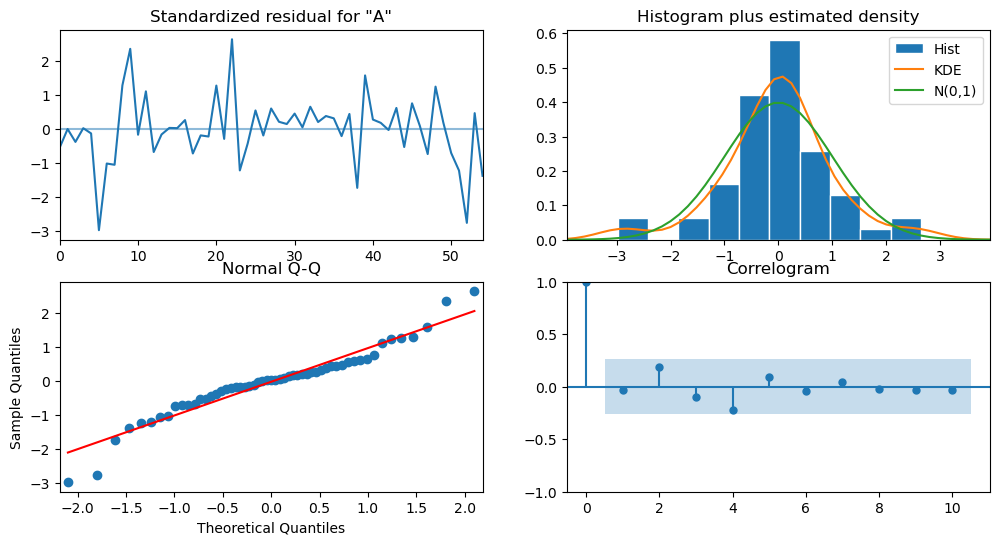

In [120]:
# Fit AR(1) model 
model_1 = ARIMA(df['Accounting'], order = (1, 0, 0)) 
result_1 = model_1.fit()

result_1.plot_diagnostics(figsize = (12, 6))

Model 2 [ARIMA(1, 3, 2]: $$(1 - \Phi_1 B)(1-B)^3 Y_t = \alpha + (1 + \Theta_1 B + \Theta_2 B^2) \epsilon_t $$

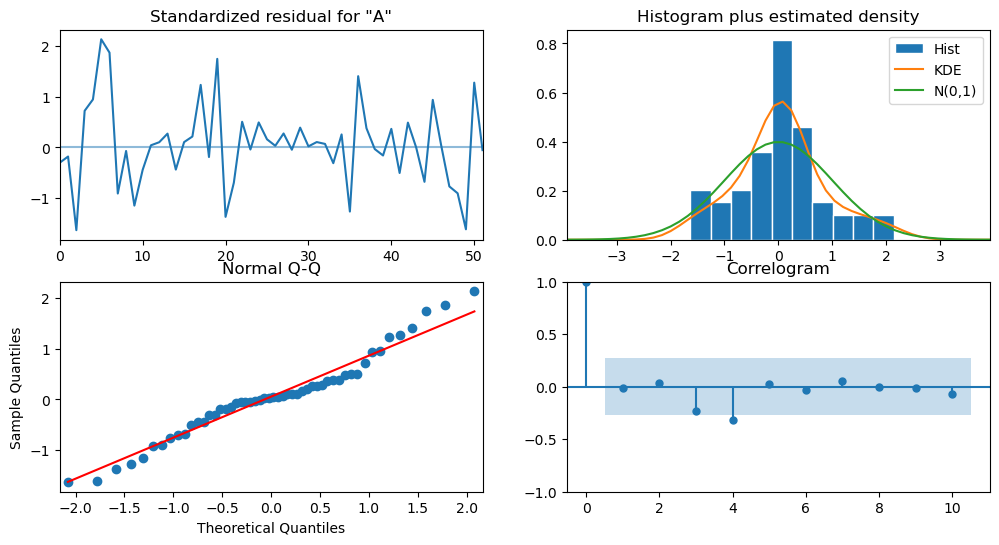

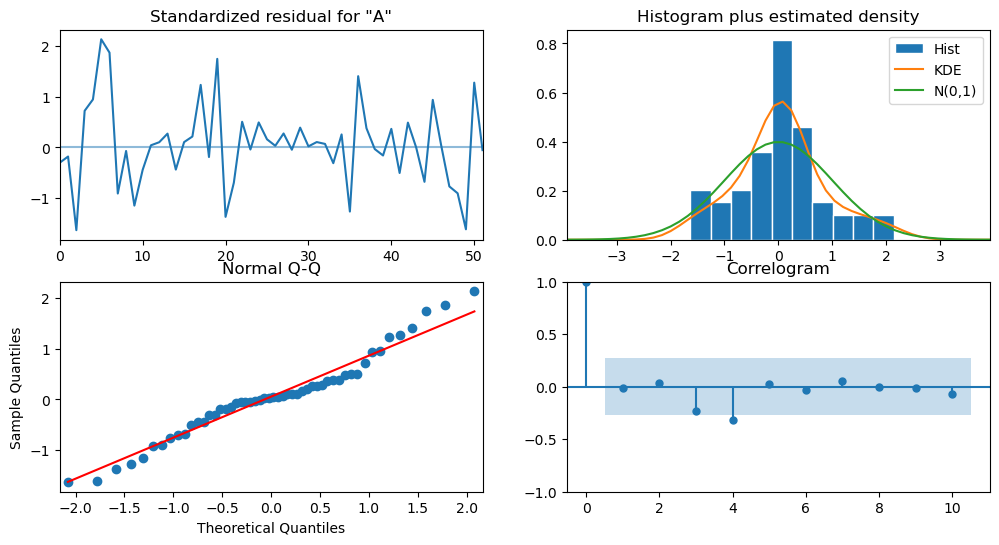

In [121]:
result_2.plot_diagnostics(figsize = (12, 6))

### Forecast

C:\Users\lwando.mbanguta.psc\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


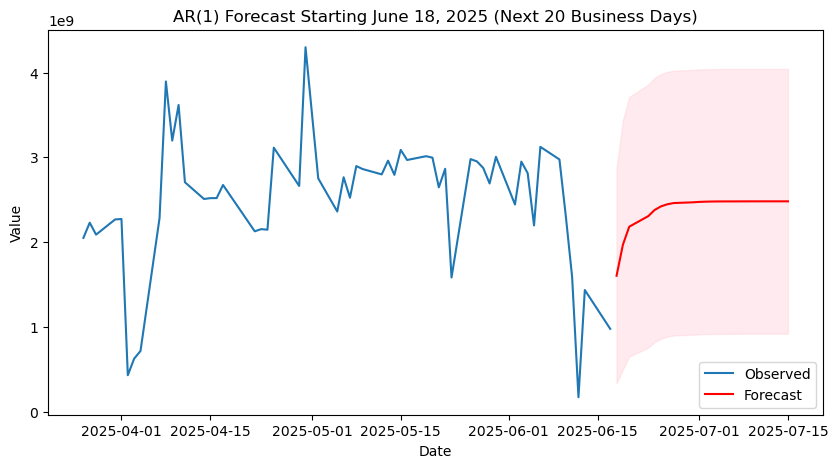

In [147]:
# Your last observed date before forecast
last_date = pd.Timestamp('2025-06-17')
# Generate next 20 business days starting **after** last_date
forecast_index = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=20)

#Model 1
forecast_steps = 20
forecast = result_1.get_forecast(steps = forecast_steps)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Set the index of forecast to this business day range
forecast_mean.index = forecast_index
conf_int.index = forecast_index

plt.figure(figsize=(10, 5))

# Plot historical data (optional)
plt.plot(df['Accounting'], label='Observed')

# Plot forecast mean and confidence intervals
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

plt.title('AR(1) Forecast Starting June 18, 2025 (Next 20 Business Days)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

C:\Users\lwando.mbanguta.psc\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


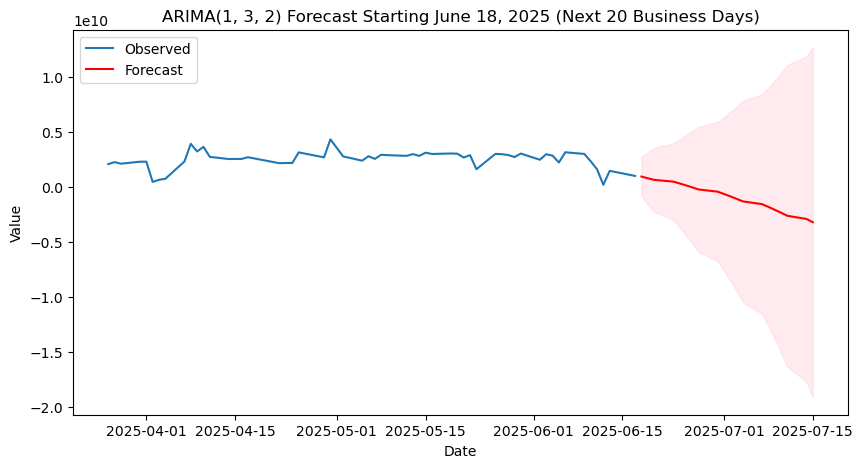

In [148]:
#Model 1
forecast_steps = 20
forecast = result_2.get_forecast(steps = forecast_steps)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Set the index of forecast to this business day range
forecast_mean.index = forecast_index
conf_int.index = forecast_index

plt.figure(figsize=(10, 5))

# Plot historical data (optional)
plt.plot(df['Accounting'], label='Observed')

# Plot forecast mean and confidence intervals
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

plt.title('ARIMA(1, 3, 2) Forecast Starting June 18, 2025 (Next 20 Business Days)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()